# <center><font color=Purple>Capstone Project-2</font>
## <center><font color=Purple>British Airways customer reviews-Sentiment analysis</font>

## <font color=Green>Sentiment analysis identifies the emotional tone behind a body of text. It's used in social media monitoring, allowing businesses to gain insights about how customers feel about certain topics, and detect urgent issues in real time before they spiral out of control.</font>

# Loading the required Libraries

In [2]:
# Standard Libraries

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# For Web Scrapping
import requests
from bs4 import BeautifulSoup

# For Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer   
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS
from collections import defaultdict

# For sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# For model building and performance metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score, recall_score, f1_score

# Collecting Data

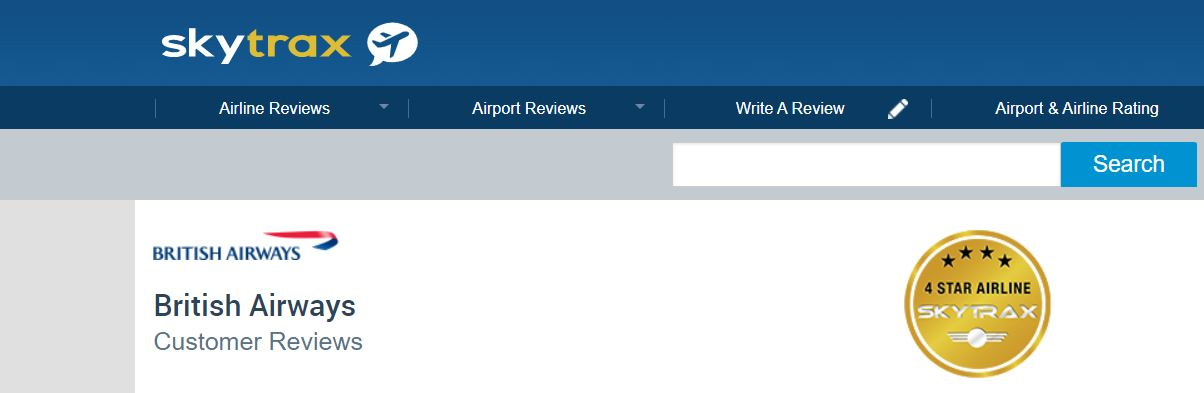

## <font color=Green>Collecting data from "Skytrax" website. Skytrax is a comprehensive Airline and Airport customer review site for airlines and airports across the world. This Website will be used for web scraping flight reviews of "British Airways" only.</font>

# Extracting reviews from "Skytrax" website

In [ ]:
#create an empty list to collect all reviews
reviews  = []

#create an empty list to collect rating stars
stars = []

#create an empty list to collect date
date = []

#create an empty list to collect country the reviewer is from
country = []

In [ ]:
for i in range(1, 36):
    page = requests.get(f"https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/?sortby=post_date%3ADesc&pagesize=100")
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    for item in soup.find_all("div", class_="text_content"):
        reviews.append(item.text)
    
    for item in soup.find_all("div", class_ = "rating-10"):
        try:
            stars.append(item.span.text)
        except:
            print(f"Error on page {i}")
            stars.append("None")
            
    #date
    for item in soup.find_all("time"):
        date.append(item.text)
        
    #country
    for item in soup.find_all("h3"):
        country.append(item.span.next_sibling.text.strip(" ()"))

In [ ]:
#check the length of total reviews extracted
len(reviews)

In [ ]:
len(country)

In [ ]:
len(stars)

In [ ]:
#check the length 
stars = stars[:3460]

In [ ]:
#create  a dataframe from these collected lists of data

df = pd.DataFrame({"reviews":reviews,"stars": stars, "date":date, "country": country})

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
# Storing reviews into a csv format
#cwd = os.getcwd()
df.to_csv("df.csv",index=False)

## <font color=Green>We have collected the required data for this task.</font> 
## <font color=Green>The loop above collected 3460 reviews by iterating through the pages on the website.</font> 
## <font color=Green>Next step is cleaning this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed wherever it exists as it's not relevant.</font>

In [3]:
# Loading the dataset
df = pd.read_csv("df.csv")

In [6]:
df.head()

,reviews,stars,country
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,\n\t\t\t\t\t\t\t\t\t\t\t\t\t5,United States
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,United Kingdom
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,United Kingdom
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,United Kingdom
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,United Kingdom


# 1. Data Preprocessing

In [5]:
df = df.drop(["date"] , axis=1)

## 1.1.Removing the symbol " | " 

## 1.2.Regular Expressions

### <font color=Green>sub() function belongs to the Regular Expressions ( re ) module in Python.</font> 
### <font color=Green>The re. sub() function stands for substring and returns a string with replaced values.</font> 
### <font color=Green>Here, our goal is to replace all the numbers, special characters like "@,#%&.* with blank.</font> 

## 1.3.Converting into Lower Case

### <font color=Green>Using lower() function to covert each word from upper case to lower case. Lowercasing the text,merges all the variations of the same word, which can simplify the data and make it easier to work with. It also helps to create a more consistent dataset by making all the text the same case, which can improve the performance of NLP models and tasks.It is important to note that lowercasing should be done before removing stopwords because stopwords are usually in lowercase. </font> 

## 1.4.Word Tokenization

### <font color=Green> Word tokenization is the process of splitting a large sample of text into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis like classifying and counting them for a particular sentiment etc.</font> 

## 1.7.Removing Stopwords

### <font color=green> Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”. In NLP , stop words are used to eliminate unimportant words, allowing applications to focus on the important words instead.</font> 

## 1.8.Lemmatization

### <font color=green> Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different forms of words into the root form, having the same meaning.</font> 

In [7]:
#for lemmatization of words we will use nltk library
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemma = WordNetLemmatizer()


reviews_data = df.reviews.str.strip("✅ Trip Verified |")

#create an empty list to collect cleaned data corpus
corpus =[]

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

In [8]:
# add the corpus to the original dataframe
df['corpus'] = corpus

In [21]:
df.head()

,reviews,stars,country,corpus
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,5,United States,verified seems race bottom amongst airline cannot even check ba requires submission document cov...
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,United Kingdom,verified spanish born individual living england using british airway decade multiple time year t...
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,United Kingdom,rather empty quiet flight tel aviv friendly cabin crew due emptiness flight entire row allowed w...
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,United Kingdom,easy check staff member polite helpful made specific point acknowledging loyalty ba security lon...
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,United Kingdom,silver flyer booking flight ba dublin would thought could use lounge even though ba used air lin...


# Checking for null values

In [22]:
df.isnull().sum()

reviews    0
stars      0
country    0
corpus     0
dtype: int64

In [23]:
# cleaning the column "stars"
df["stars"].value_counts()

1     748
2     389
3     384
8     350
10    311
7     301
9     297
5     259
4     232
6     183
Name: stars, dtype: int64

### we can see it contains 35 text values like "\n\t\t\t\t\t\t\t\t\t\t\t\t\t5 " and 4 "none"   

In [24]:
# remove the "\n\t\t\t\t\t\t\t\t\t\t\t\t\t5" from the ratings
df["stars"] = df["stars"].str.strip("\n\t\t\t\t\t\t\t\t\t\t\t\t\t")

In [25]:
# locate rows with value "none"
df[df['stars'] == "None"]

,reviews,stars,country,corpus


In [26]:
# drop the rows where the value of ratings is None
df.drop(df[df.stars == "None"].index, axis=0, inplace=True)

In [27]:
df["stars"].value_counts()

1     748
2     389
3     384
8     350
10    311
7     301
9     297
5     259
4     232
6     183
Name: stars, dtype: int64

In [31]:
# checking country columns with null values
df[df.country.isnull()]

,reviews,stars,country,corpus


In [32]:
# drop the rows where the value of country is null
df = df.dropna()

In [33]:
df.isnull().sum()

reviews    0
stars      0
country    0
corpus     0
dtype: int64

In [34]:
len(df)

3454

### Pre-processing steps are completed. We can use this data for for creating visualizations.

# 4.Visualization

## 4.1.Top 50 words with highest frequency in our dataset

In [20]:
all_words = df['corpus'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.values[2:50],
            y = all_words.index.values[2:50],
            
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            orientation= 'h',
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies in the dataset',
    height =1000,
    
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 4.2.WordCloud of our dataset

## <font color=green>A word cloud, is a visual representation of the most common words in a text or a set of texts. It is a way to quickly understand the main themes or topics in a text, and the relative importance of each theme.</font> 

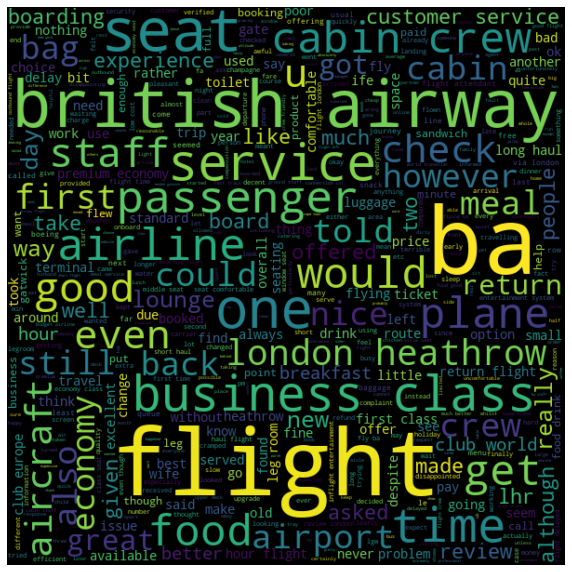

In [23]:
import nltk
from nltk.corpus import stopwords
# Start with one review:
reviews = " ".join(df.corpus)
plt.figure(figsize=(10,15))

stopwords = set(stopwords.words('english'))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 4.3. Ratings

In [ ]:
#What is the average overall rating given for British Airways?
df.stars.mean()

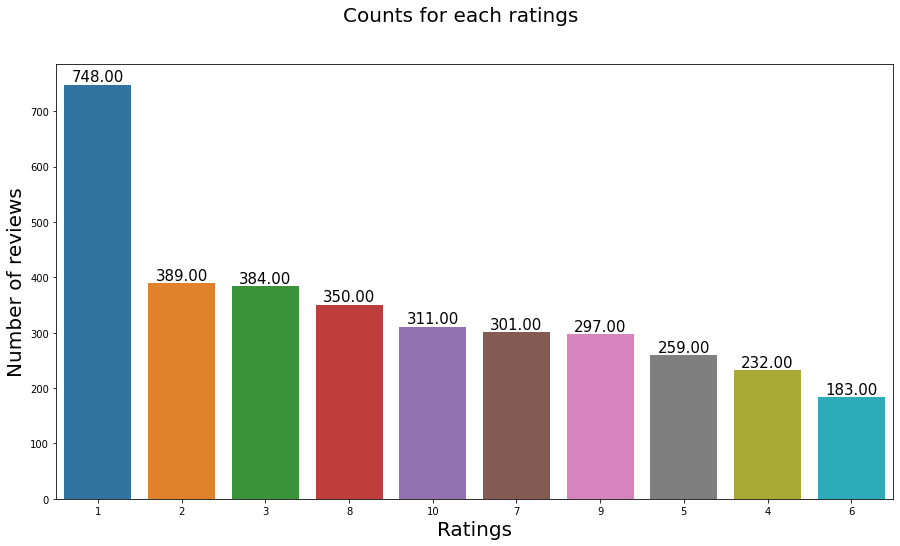

In [75]:
# Total count of each rating in the dataset
plt.figure(figsize=(15,8))
plots = sns.countplot(x=df.stars , data= df , order=df["stars"].value_counts().index)
plt.xlabel("Ratings",fontsize= 20)
plt.ylabel("Number of reviews",fontsize= 20)
plt.suptitle("Counts for each ratings",fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

### Total no. of reviews are = 3454
### 58 % of the customers have given 5 or less than 5 rating
### Only 9% have given 10 stars

# 4.4.Top 10 countries in our data

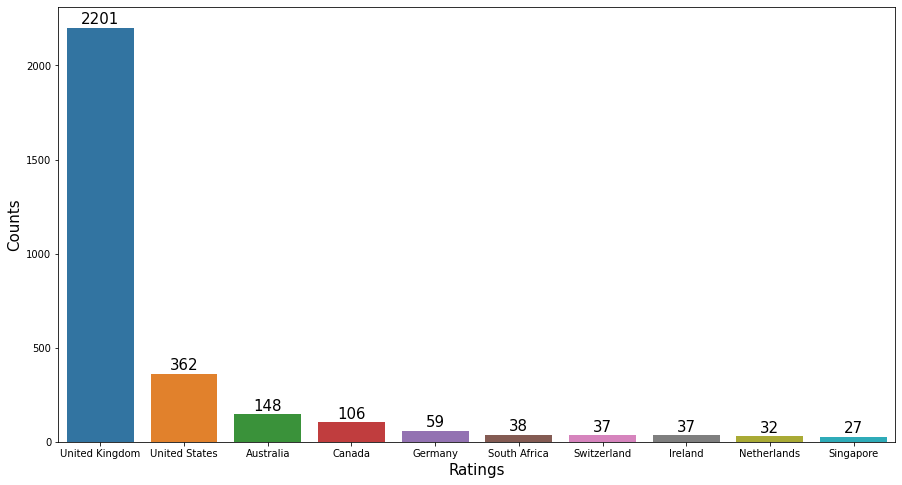

In [111]:
plt.figure(figsize=(15,8))
plots= sns.countplot(x=df.country, data= df, order=df.country.value_counts().iloc[:10].index)
plt.xlabel("Ratings",fontsize= 15)
plt.ylabel("Counts",fontsize= 15)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

# 4.5.From which country most review comes ?

Text(0, 0.5, 'Counts')

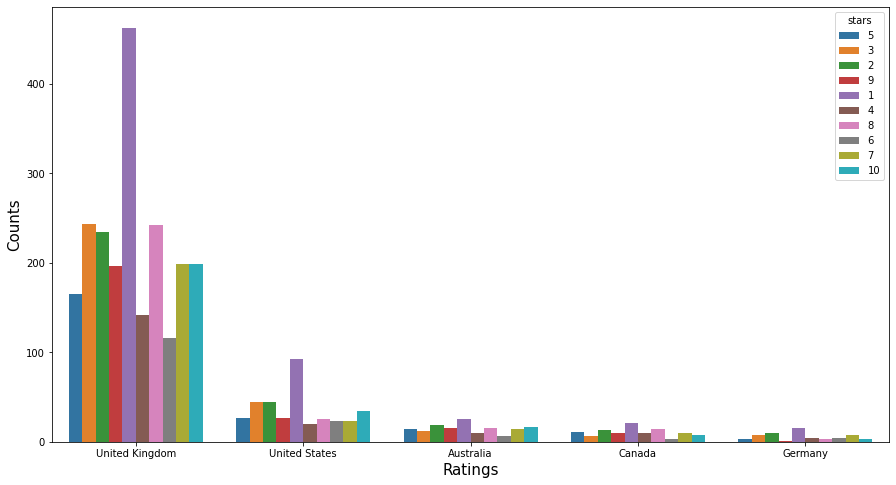

In [114]:
plt.figure(figsize=(15,8))
plots= sns.countplot(x=df.country,hue=df.stars, data= df, order=df.country.value_counts().iloc[:5].index)
plt.xlabel("Ratings",fontsize= 15)
plt.ylabel("Counts",fontsize= 15)

# Word Frequency with N-gram

<AxesSubplot:>

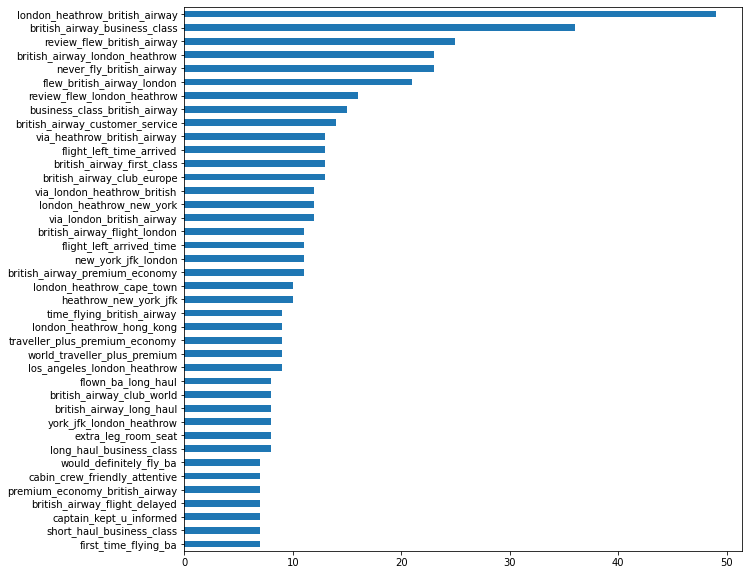

In [43]:
## Imports
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
#from wordcloud import WordCloud, STOPWORDS
#import nltk.collocations as collocations
from nltk import FreqDist, bigrams

reviews = " ".join(df.corpus)

#split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words,number_of_ngrams ):
    from nltk import ngrams
    
    ## Generate bigrams
    ngrams = ngrams(new_words, number_of_ngrams)

    ## Creating FreqDist
    ngram_fd = FreqDist(ngrams).most_common(40)

    ## Sort values by highest frequency
    ngram_sorted = {k:v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ## Join bigram tokens with '_' + maintain sorting
    ngram_joined = {'_'.join(k):v for k,v in sorted(ngram_fd, key=lambda item:item[1])}

    ## Convert to Pandas series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10,10))
    ax = ngram_freqdist.plot(kind="barh")
    
    return ax


get_freq_dist(new_words,4)

### We can see that there are very common positive terms regarding cabin crew. For example, cabin_crew_friendly_helpful, cabin_crew_friendly_attentive, cabin_crew_friendly_efficient, etc. So certainly customers are providing good reviews about cabin crew staff of British Airways.

In [64]:
df.head()

,reviews,stars,country,corpus
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,5,United States,verified seems race bottom amongst airline cannot even check ba requires submission document cov...
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,United Kingdom,verified spanish born individual living england using british airway decade multiple time year t...
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,United Kingdom,rather empty quiet flight tel aviv friendly cabin crew due emptiness flight entire row allowed w...
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,United Kingdom,easy check staff member polite helpful made specific point acknowledging loyalty ba security lon...
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,United Kingdom,silver flyer booking flight ba dublin would thought could use lounge even though ba used air lin...


# Sentiment analysis

### <font color=green> For Sentiment Analysis, we’ll use VADER Sentiment Analysis, where VADER means Valence Aware Dictionary and sentiment Reasoner.</font> 
### <font color=green> VADER tells us how positive or negative a statement is.VADER sentiment analysis (well, in the Python implementation anyway) returns a sentiment score in the range -1 to 1, from most negative to most positive. The sentiment score of a sentence is calculated by summing up the sentiment scores of each VADER-dictionary-listed word in the sentence.</font> 

In [38]:
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['corpus'].apply(vadersentimentanalysis)


def vader_analysis(compound):                
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)

In [39]:
df.head(100)

,reviews,stars,date,country,corpus,Sentiment,Analysis
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,5,19th January 2023,United States,verified seems race bottom amongst airline cannot even check ba requires submission document cov...,-0.8779,Negative
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,19th January 2023,United Kingdom,verified spanish born individual living england using british airway decade multiple time year t...,0.8669,Positive
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,18th January 2023,United Kingdom,rather empty quiet flight tel aviv friendly cabin crew due emptiness flight entire row allowed w...,0.2960,Positive
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,17th January 2023,United Kingdom,easy check staff member polite helpful made specific point acknowledging loyalty ba security lon...,0.9732,Positive
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,17th January 2023,United Kingdom,silver flyer booking flight ba dublin would thought could use lounge even though ba used air lin...,0.7096,Positive
...,...,...,...,...,...,...,...
95,✅ Trip Verified | My wife and I booked a flight in April 2022 that included a return trip from ...,1,22nd July 2022,United States,wife booked flight april included return trip edinburgh thru london washington checked edinburgh...,0.8625,Positive
96,"Not Verified | Decent flight and airplane, non existing customer service for refunds and suppor...",1,20th July 2022,Netherlands,verified decent flight airplane non existing customer service refund support delayed flight flig...,0.8271,Positive
97,Not Verified | Reasonably smooth boarding. Meal service was smooth ad efficient but no ice or s...,1,18th July 2022,United Kingdom,verified reasonably smooth boarding meal service smooth ad efficient ice spirit available room t...,0.3182,Positive
98,"✅ Trip Verified | Three flights, London to Reykjavik return and Frankfurt to London. Generally ...",5,18th July 2022,Australia,hree flight london reykjavik return frankfurt london generally flight acceptable standard though...,-0.5267,Negative


In [40]:
df['Analysis'].value_counts()

Positive    2351
Negative    1040
Neutral       63
Name: Analysis, dtype: int64

In [41]:
values = [2351,1040,63]
labels=["Neutral","Positive","Negative"]
fig = px.pie(values=values,names=labels)
fig.show()

# Plotting wordcloud for Positive reviews

In [42]:
postive_reviews = df[df["Analysis"]=="Positive"]

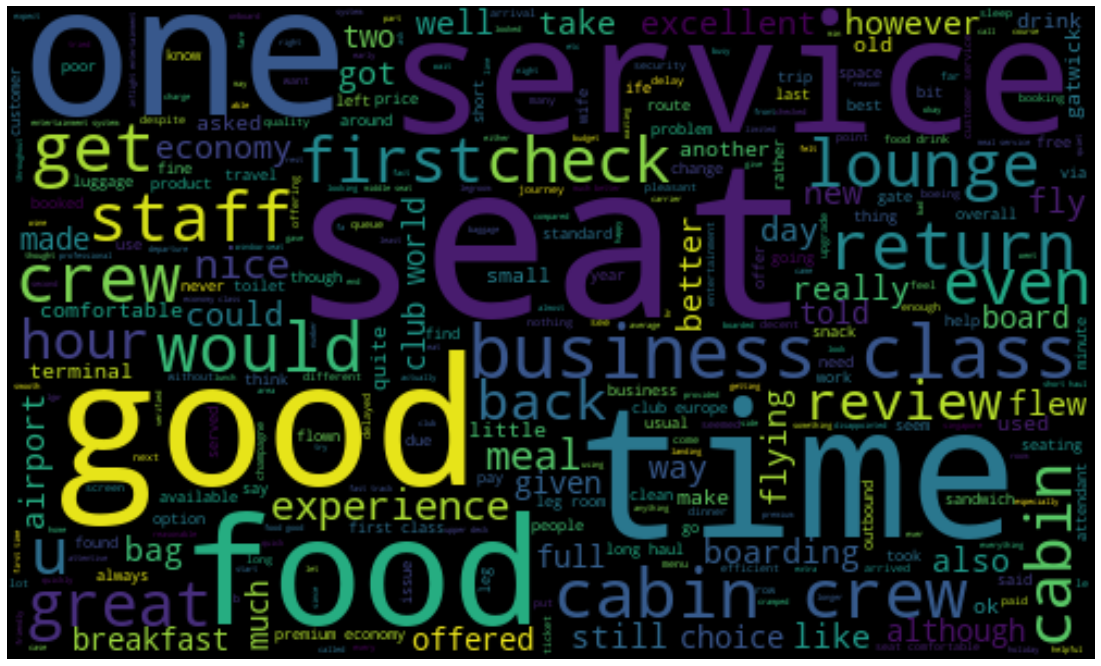

In [122]:
import nltk
from nltk.corpus import stopwords
p = " ".join(postive_reviews.corpus)
plt.figure(figsize=(20,12))

stopwords = set(stopwords.words('english'))
stopwords.update(["ba","flight", "british","airway", "airline","plane","passenger","lhr",
                 "London", "heathrow", "aircraft"])
# Create and generate a word cloud image:
wordcloud = WordCloud(height=300,width=500,max_font_size=100, max_words=300, stopwords=stopwords).generate(p)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Plotting wordcloud for Negative reviews

In [44]:
negative_reviews = df[df["Analysis"]=="Negative"]

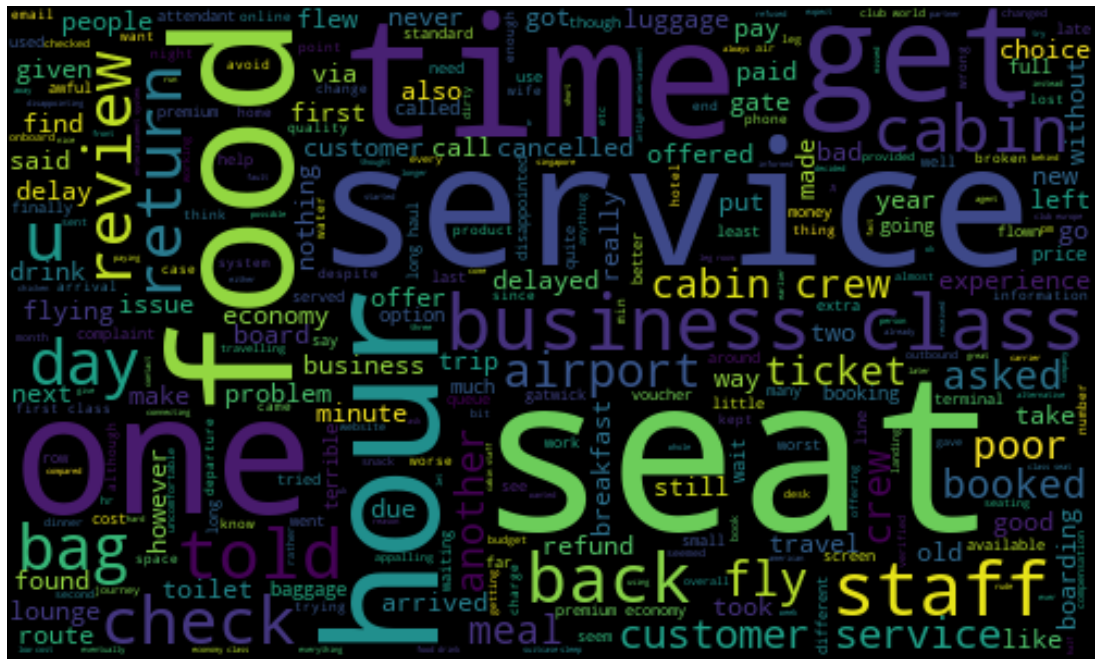

In [133]:
import nltk
from nltk.corpus import stopwords
n = " ".join(negative_reviews.corpus)
plt.figure(figsize=(20,12))

stopwords = set(stopwords.words('english'))
stopwords.update(["ba","flight", "british","airway", "airline","plane","passenger","lhr","seat"
                 "london","London", "heathrow", "aircraft","could","even", "would"])
# Create and generate a word cloud image:
wordcloud = WordCloud(height=300,width=500,max_font_size=100, max_words=300, stopwords=stopwords).generate(n)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
# dopping column "Sentiment" 
data = df.drop(["Sentiment"] , axis=1)

In [134]:
data.head()

,reviews,stars,date,country,corpus,Analysis
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,5,19th January 2023,United States,verified seems race bottom amongst airline cannot even check ba requires submission document cov...,0
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,19th January 2023,United Kingdom,verified spanish born individual living england using british airway decade multiple time year t...,2
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,18th January 2023,United Kingdom,rather empty quiet flight tel aviv friendly cabin crew due emptiness flight entire row allowed w...,2
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,17th January 2023,United Kingdom,easy check staff member polite helpful made specific point acknowledging loyalty ba security lon...,2
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,17th January 2023,United Kingdom,silver flyer booking flight ba dublin would thought could use lounge even though ba used air lin...,2


### Converting the categorical target variable into numeric format

In [135]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data['Analysis']= label_encoder.fit_transform(data['Analysis'])
  
data['Analysis'].unique()

array([0, 2, 1], dtype=int64)

In [136]:
data.head()

,reviews,stars,date,country,corpus,Analysis
0,Not Verified | It seems that there is a race to the bottom amongst airlines. I cannot even check...,5,19th January 2023,United States,verified seems race bottom amongst airline cannot even check ba requires submission document cov...,0
1,"Not Verified | As a Spanish born individual living in England, I have been using British Airway...",3,19th January 2023,United Kingdom,verified spanish born individual living england using british airway decade multiple time year t...,2
2,"✅ Trip Verified | A rather empty and quiet flight to Tel Aviv, very friendly cabin crew and due...",2,18th January 2023,United Kingdom,rather empty quiet flight tel aviv friendly cabin crew due emptiness flight entire row allowed w...,2
3,✅ Trip Verified | Easy check in and staff member was polite and helpful and made a specific poi...,9,17th January 2023,United Kingdom,easy check staff member polite helpful made specific point acknowledging loyalty ba security lon...,2
4,✅ Trip Verified | Being a silver flyer and booking a flight through BA to Dublin you would have...,9,17th January 2023,United Kingdom,silver flyer booking flight ba dublin would thought could use lounge even though ba used air lin...,2


### 0 is for "Negative"
### 1 is for "Neutral"
### 2 is for "Positive"

In [137]:
data["Analysis"].value_counts()

2    2351
0    1040
1      63
Name: Analysis, dtype: int64

# Using TfidfVectorizer

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the text data
x = tfidf_vectorizer.fit_transform(data["corpus"]).toarray()

In [139]:
x = pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,...,11120,11121,11122,11123,11124,11125,11126,11127,11128,11129
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.098522,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
x.shape

(3454, 11130)

In [141]:
y = data['Analysis']
y.head()

0    0
1    2
2    2
3    2
4    2
Name: Analysis, dtype: int64

In [142]:
y.shape

(3454,)

# Split the data into training and test 

In [143]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=111)

In [144]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2417, 11130)
(1037, 11130)
(2417,)
(1037,)


# Model Building

## 1.Naive Bayes 

In [145]:
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(x_train, y_train)

GaussianNB()

## Predicting using the model

In [146]:
y_pred_nb_train = classifier_nb.predict(x_train)
y_pred_nb_test = classifier_nb.predict(x_test)

## Evaluating the model

In [147]:
# confusion matrix on test data
cm_nb_test = confusion_matrix(y_test, y_pred_nb_test)

## 2.SVM

In [148]:
# Using Kerner = 'linear' / 'sigmoid' / 'rbf'

from sklearn.svm import SVC

classifier_svm_linear = SVC(kernel='linear')
classifier_svm_linear.fit(x_train, y_train)

classifier_svm_sigmoid = SVC(kernel='sigmoid')
classifier_svm_sigmoid.fit(x_train, y_train)

classifier_svm_rbf = SVC(kernel='rbf')
classifier_svm_rbf.fit(x_train, y_train)

SVC()

## Predicting using the model

In [149]:
y_pred_linear_train = classifier_svm_linear.predict(x_train)
y_pred_sigmoid_train = classifier_svm_sigmoid.predict(x_train)
y_pred_rbf_train = classifier_svm_rbf.predict(x_train)

In [150]:
y_pred_linear_test = classifier_svm_linear.predict(x_test)
y_pred_sigmoid_test = classifier_svm_sigmoid.predict(x_test)
y_pred_rbf_test = classifier_svm_rbf.predict(x_test)

## Evaluating the model

In [151]:
# confusion matrix on test data
cm_svm_test_linear = confusion_matrix(y_test, y_pred_linear_test)
cm_svm_test_sigmoid = confusion_matrix(y_test, y_pred_sigmoid_test)
cm_svm_test_rbf = confusion_matrix(y_test, y_pred_rbf_test)

# Ensemble methods
## Bagging

# RandomForest Algorithm

In [152]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier()
rforest.fit(x_train, y_train)

RandomForestClassifier()

## Predicting using the model

In [153]:
y_pred_rf_train = rforest.predict(x_train)
y_pred_rf_test = rforest.predict(x_test)

## Evaluating using the model

In [154]:
# confusion matrix on test data
cm_rf_test = confusion_matrix(y_test, y_pred_rf_test)

# Boosting

# Gradient Boosting Algorithm

In [155]:
from sklearn.ensemble import GradientBoostingClassifier
gdboost = GradientBoostingClassifier()
gdboost.fit(x_train, y_train)

GradientBoostingClassifier()

## Predicting using the model

In [156]:
y_pred_gb_train = gdboost.predict(x_train)
y_pred_gb_test = gdboost.predict(x_test)

## Evaluating using the model

In [157]:
# confusion matrix on test data
cm_gb_test = confusion_matrix(y_test, y_pred_gb_test)

In [158]:
# accuracy_score on train & test data
acc_gb_train = accuracy_score(y_train, y_pred_gb_train)
acc_gb_test = accuracy_score(y_test, y_pred_gb_test)

# Adaboost Algorithm

In [159]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)

AdaBoostClassifier()

## Predicting using the model

In [160]:
y_pred_ada_train = ada.predict(x_train)
y_pred_ada_test = ada.predict(x_test)

## Evaluating using the model

In [161]:
# confusion matrix test data
cm_ada_test = confusion_matrix(y_test, y_pred_ada_test)

# Xgboost

In [162]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

## Predicting using the model

In [163]:
y_pred_xgb_train = xgb.predict(x_train)
y_pred_xgb_test = xgb.predict(x_test)

## Evaluating using the model

In [164]:
# confusion matrix on test data
cm_xgb_test = confusion_matrix(y_test, y_pred_xgb_test)

# Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
logit.fit(x_train, y_train)

LogisticRegression()

## Predicting using the model

In [166]:
y_pred_logit_train = logit.predict(x_train)
y_pred_logit_test = logit.predict(x_test)

## Evaluating using the model

In [167]:
# confusion matrix on test data
cm_logit_test = confusion_matrix(y_test, y_pred_logit_test)

# DecisionTree

In [168]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

## Predicting using the model

In [169]:
y_pred_dt_train = dt.predict(x_train)
y_pred_dt_test = dt.predict(x_test)

## Evaluating using the model

In [170]:
# confusion matrix on test data
cm_dt_test = confusion_matrix(y_test, y_pred_dt_test)

# Visualization of Confision Matrix

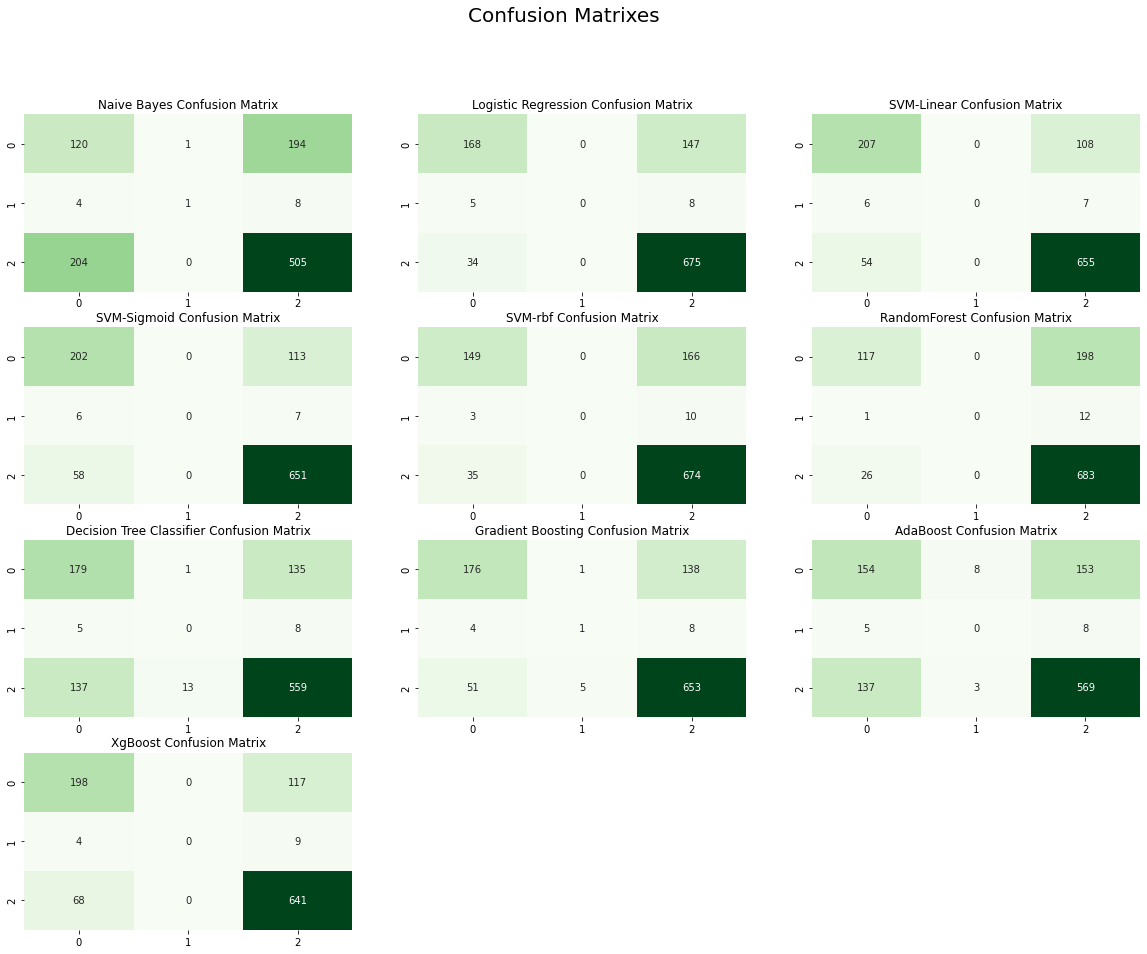

In [171]:
plt.figure(figsize=(20,15))

plt.suptitle("Confusion Matrixes",fontsize=20)

plt.subplot(4,3,1)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,2)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_logit_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,3)
plt.title("SVM-Linear Confusion Matrix")
sns.heatmap(cm_svm_test_linear,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,4)
plt.title("SVM-Sigmoid Confusion Matrix")
sns.heatmap(cm_svm_test_sigmoid,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,5)
plt.title("SVM-rbf Confusion Matrix")
sns.heatmap(cm_svm_test_rbf,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,6)
plt.title("RandomForest Confusion Matrix")
sns.heatmap(cm_rf_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,7)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dt_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,8)
plt.title("Gradient Boosting Confusion Matrix")
sns.heatmap(cm_gb_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,9)
plt.title("AdaBoost Confusion Matrix")
sns.heatmap(cm_ada_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.subplot(4,3,10)
plt.title("XgBoost Confusion Matrix")
sns.heatmap(cm_xgb_test,cbar=False,annot=True,cmap="Greens",fmt="d")

plt.show()

# Accuracy of all models

In [174]:
# List of all models defined
models_list_1 = [classifier_nb, 
          
          classifier_svm_linear, classifier_svm_sigmoid, classifier_svm_rbf, 
          
          rforest, gdboost, ada, xgb, 
          
          logit, dt]
        

# List of model name required
model_names_1 = ["Naive Bayes Classifier", 
                 
                 "SVM_linear Classifier","SVM_Sigmoid Classifier","SVM_rbf Classifier",
                 
                 "RadnomForest Classifier","GradientBoost","AdaBoost","XGBoost",
                
                "LogisticRegression Classifier" , "DecisionTree Classifier"]

# List to store the metrics for each model
result_1 = []

# Loop through each model
for i, model in enumerate(models_list_1):
    model__name = model_names_1[i]
    print(model__name)
    
    # Fit the model to the training data
    model.fit(x_train, y_train)
    
    # Make predictions on the train data
    y_pred_train = model.predict(x_train)
    
    # Make predictions on the test data
    y_pred_test = model.predict(x_test)
    
    # Calculate the performance metrics
    train_accuracy = accuracy_score(y_train , y_pred_train)                        # accuracy on train data
    
    test_accuracy = accuracy_score(y_test, y_pred_test)                            # accuracy on test data
    
    f1 = f1_score(y_test, y_pred_test , average='micro')                           # F1 score on test data
    
    recall = recall_score(y_test, y_pred_test , average='micro')                   # Recall on test data
    
    precision = precision_score(y_test, y_pred_test , average='micro')            # Precision on test data
    
    result_1.append([model__name, train_accuracy,test_accuracy,f1 ,recall, precision])           # append all result in list

    
# Print the results in a table format
Model_summary_1 = pd.DataFrame(result_1, columns=['Model','Train Accuracy','Test Accuracy','F1-Score','Recall','Precision'])

Naive Bayes Classifier
SVM_linear Classifier
SVM_Sigmoid Classifier
SVM_rbf Classifier
RadnomForest Classifier
GradientBoost
AdaBoost
XGBoost
LogisticRegression Classifier
DecisionTree Classifier


In [176]:
Model_summary_1

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score
0,Naive Bayes Classifier,0.918908,0.603664,0.603664,0.603664,0.603664
1,SVM_linear Classifier,0.962350,0.831244,0.831244,0.831244,0.831244
2,SVM_Sigmoid Classifier,0.928010,0.822565,0.822565,0.822565,0.822565
3,SVM_rbf Classifier,0.978486,0.793635,0.793635,0.793635,0.793635
4,RadnomForest Classifier,1.000000,0.757956,0.757956,0.757956,0.757956
5,GradientBoost,0.947456,0.807136,0.807136,0.807136,0.807136
6,AdaBoost,0.719073,0.697203,0.697203,0.697203,0.697203
7,XGBoost,1.000000,0.809065,0.809065,0.809065,0.809065
8,LogisticRegression Classifier,0.937526,0.812922,0.812922,0.812922,0.812922
9,DecisionTree Classifier,1.000000,0.721311,0.721311,0.721311,0.721311


### 1.Best Model will be SVM with kernel as Linear.
### 2.SVM_Linear shows maximum accuracy on test data. This can be seen in the confusion matrix also.
### 3.Train accuracy is also good as compared to other models.
### 4.Variation is also less as compared to other models.

# <center><font color=Purple>The End</font>
